In [1]:
# encoding: utf-8
# Author: Zhuangwei Kang

import os, sys
import matplotlib.pyplot as plt
from matplotlib import style
sys.path.append('../../')
from datapsr import *
import numpy as np
style.use(['classic'])
plt.rc('axes', axisbelow=True)
dpi=600

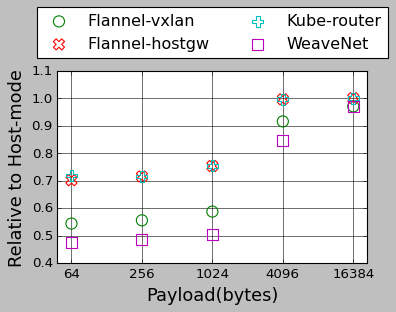

In [7]:
plt.figure(figsize=(5,3))
plugins = ['hostnetwork-udp', 'flannel-vxlan-udp', 'flannel-hostgw-udp', 'kube-router-udp', 'weavenet-udp']
data_len = [64, 256, 1024, 4096, 16384]
perf, _ = load_data(range(len(data_len)), plugins)

plt.xticks(range(len(data_len)), data_len)
markers = ['^', 'o', 'X', 'P', 's']
labels = ['Host-mode', 'Flannel-vxlan', 'Flannel-hostgw', 'Kube-router', 'WeaveNet']
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(plugins)-1
width = total_width / n
# x = x - (total_width - width) / 2
baseline = perf[perf['cni'] == 'hostnetwork-udp']['mbps(ave)'].to_numpy()
for i, cni in enumerate(plugins):
    if i == 0:
        continue
    throughput = perf[perf['cni'] == cni]['mbps(ave)'].to_numpy()
    plt.scatter(x, throughput/baseline, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)
    # print(100*(1- throughput/baseline))
    # plt.scatter(x, throughput/baseline, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)
    # print(100*(1- throughput/baseline))
#     plt.bar(x+(i-1)*width, throughput/baseline, label=labels[i], width=width)
    # plt.plot(x_vals, throughput, label='-'.join(cni.split('-')[:-1]).upper(), marker='o')

# plt.yticks(np.arange(0,12,2)/10)
# plt.ylim(0.4, 1)
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to Host-mode', fontsize=16)
plt.grid(linestyle='-')
plt.savefig('throughput.png', dpi=dpi, bbox_inches='tight')


Description: In this experiment, we deployed each RTI-perftest application(publisher/subscriber) in a K8s pod that is hosted on an individual Raspberry Pi. We evaluated DDS application performance on the Hybrid-Arch K8s cluster with Flannel, Kube-router, and Weavenet, being installed respectively.

Purpose: This experiment intends to quantify performance overhead imposed by different K8s CNIs on DDS applications. 

Analysis: Experiment results reveal that CNIs relying on VXLAN encapsulation, such as Flannel-VXLAN and Weavenet, suffer severe throughput degradation compared to others, coincident with our qualitative analysis. However, Weavenet(fastpath) gains even lower throughput than Flannel-VXLAN. Note although the default Weavenet MTU size is 1376 bytes, the maximum effective one detected by Weavenet on our Raspberry Pis is 1438 bytes. Therefore, we configure the Weavenet MTU to 1438 bytes in the rest Weavenet tests in this paper. This observation also illustrates that the Open vSwitch-based VXLAN encapsulation employed by Weavenet introduces more performance overhead compared to the native VXLAN encapsulation used by Flannel. Flannel-Host-gw mode outperforms Kuberouter by 17.2% ~ 18.6% when sending small messages(<=1KB), which is as expected because Flannel completely avoids MTU overhead(1500 bytes) in the host-gw mode by configuring each host to a network gateway, while the maximum MTU allowed by Kuberouter is 1480 bytes. Since their MTU difference is relatively small, the throughput gap between them is trivial when sending large messages. More intuitively, the average overhead of shown CNIs on specified data length settings are as follows: Flannel-Hostgw=3.8%, Flannel-VXLAN=19.7%, Weavenet=31.5%, Kuberouter=10.8%.

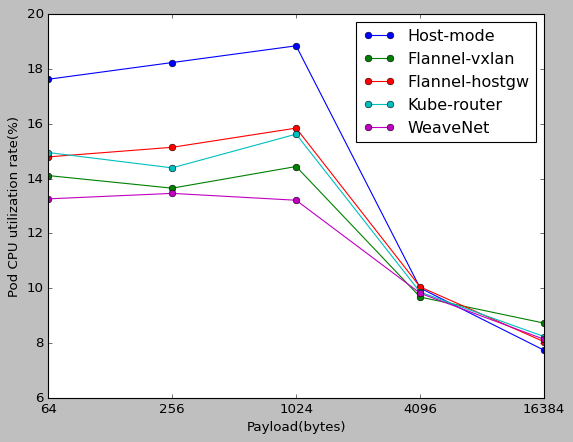

In [3]:
# _, perf = load_data(range(len(data_len)), plugins)
plt.xticks(range(len(data_len)), data_len)
for i, cni in enumerate(plugins):
    cpu = perf[perf['cni'] == cni]['cpu']
    plt.plot(np.arange(len(data_len)), cpu, label=labels[i], marker='o')
# plt.ylim(0, 100)
plt.legend()
plt.xlabel('Payload(bytes)')
plt.ylabel('Pod CPU utilization rate(%)')
# plt.grid(axis='y', linestyle=':')
plt.show()

hostnetwork-udp
flannel-vxlan-udp
flannel-hostgw-udp
kube-router-udp
weavenet-udp


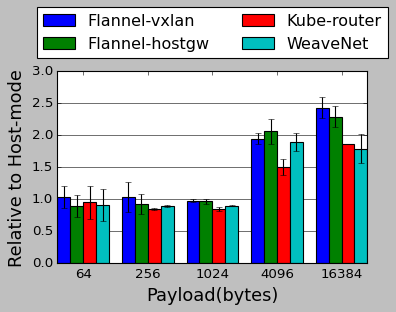

In [4]:
plt.figure(figsize=(5,3))
plt.xticks(range(len(data_len)), data_len)
pub_host_cpu = {}
sub_host_cpu = {}
x = np.arange(6)
# markers = ['o', '^', 'd', 'P']

# for j, cni in enumerate(udp_plugins):
#     pub_cpu = []
#     pub_cpu_std = []
#     sub_cpu = []
#     sub_cpu_std = []
#     for i in np.arange(6):
#         data = pd.read_csv('throughputTest/%s/test-%d/metrics.csv' % (cni, i))
#         pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(90%)'])
#         sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(90%)'])
#         pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
#         sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    
#     plt.plot(x, pub_cpu, marker=markers[j], color='C0', label=dds_secure_labels[j])
#     plt.fill_between(x, np.reshape(np.array(pub_cpu)-np.array(pub_cpu_std), len(x)), np.reshape(np.array(pub_cpu)+np.array(pub_cpu_std), len(x)), alpha=.2, color='C0')

x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(plugins)-1
width = total_width / n
x = x - (total_width - width) / 2
for j, cni in enumerate(plugins):
    print(cni)
    pub_cpu = []
    pub_cpu_std = []
    sub_cpu = []
    sub_cpu_std = []
    for i in np.arange(len(data_len)):
        data = pd.read_csv('throughputTest/%s/test-%d/metrics.csv' % (cni, i))
        pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(90%)'])
        sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(90%)'])
        pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
        sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    if j == 0:
        baseline = np.array(pub_cpu)
        continue
    
    plt.bar(x+(j-1)*width, np.reshape(np.array(sub_cpu), len(x)), yerr=np.reshape(np.array(sub_cpu_std), len(x)), width=width, color='C%d' % (j-1), label=labels[j])
    # plt.bar(x+(j-1)*width, np.reshape(np.array(sub_cpu)/baseline, len(x)), yerr=np.reshape(np.array(sub_cpu_std)/baseline, len(x)), width=width, color='C%d' % (j-1), label=labels[j])
#     plt.fill_between(x, np.reshape(np.array(pub_cpu)-np.array(pub_cpu_std), len(x)), np.reshape(np.array(pub_cpu)+np.array(pub_cpu_std), len(x)), alpha=.2, color='C%d' % (j))

# plt.ylim(0.5, 2.5)
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center')
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to Host-mode', fontsize=16)
plt.grid(axis='y', linestyle='-')
plt.savefig('cpu.png', dpi=dpi, bbox_inches='tight')

hostnetwork-udp
flannel-vxlan-udp
flannel-hostgw-udp
kube-router-udp
weavenet-udp


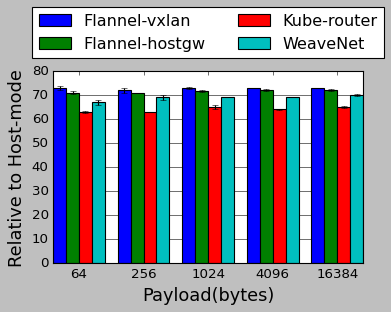

In [9]:
plt.figure(figsize=(5,3))
plt.xticks(range(len(data_len)), data_len)
pub_host_cpu = {}
sub_host_cpu = {}
x = np.arange(6)
# markers = ['o', '^', 'd', 'P']

# for j, cni in enumerate(udp_plugins):
#     pub_cpu = []
#     pub_cpu_std = []
#     sub_cpu = []
#     sub_cpu_std = []
#     for i in np.arange(6):
#         data = pd.read_csv('throughputTest/%s/test-%d/metrics.csv' % (cni, i))
#         pub_cpu.append(data[data['name'] == 'raspberrypi87']['cpu%(90%)'])
#         sub_cpu.append(data[data['name'] == 'raspberrypi89']['cpu%(90%)'])
#         pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['cpu%(std)'])
#         sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['cpu%(std)'])
    
#     plt.plot(x, pub_cpu, marker=markers[j], color='C0', label=dds_secure_labels[j])
#     plt.fill_between(x, np.reshape(np.array(pub_cpu)-np.array(pub_cpu_std), len(x)), np.reshape(np.array(pub_cpu)+np.array(pub_cpu_std), len(x)), alpha=.2, color='C0')

x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(plugins)-1
width = total_width / n
x = x - (total_width - width) / 2
for j, cni in enumerate(plugins):
    print(cni)
    pub_cpu = []
    pub_cpu_std = []
    sub_cpu = []
    sub_cpu_std = []
    for i in np.arange(len(data_len)):
        data = pd.read_csv('throughputTest/%s/test-%d/metrics.csv' % (cni, i))
        pub_cpu.append(data[data['name'] == 'raspberrypi87']['memory%(90%)'])
        sub_cpu.append(data[data['name'] == 'raspberrypi89']['memory%(90%)'])
        pub_cpu_std.append(data[data['name'] == 'raspberrypi87']['memory%(std)'])
        sub_cpu_std.append(data[data['name'] == 'raspberrypi89']['memory%(std)'])
    if j == 0:
        baseline = np.array(pub_cpu)
        continue
    
    plt.bar(x+(j-1)*width, np.reshape(np.array(sub_cpu), len(x)), yerr=np.reshape(np.array(sub_cpu_std), len(x)), width=width, color='C%d' % (j-1), label=labels[j])
    # plt.bar(x+(j-1)*width, np.reshape(np.array(sub_cpu)/baseline, len(x)), yerr=np.reshape(np.array(sub_cpu_std)/baseline, len(x)), width=width, color='C%d' % (j-1), label=labels[j])
#     plt.fill_between(x, np.reshape(np.array(pub_cpu)-np.array(pub_cpu_std), len(x)), np.reshape(np.array(pub_cpu)+np.array(pub_cpu_std), len(x)), alpha=.2, color='C%d' % (j))

# plt.ylim(0.8, 1.1)
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center')
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to Host-mode', fontsize=16)
plt.grid(axis='y', linestyle='-')
plt.savefig('memory.png', dpi=dpi, bbox_inches='tight')

[39.27536232 37.78371162 28.67570386 25.63915267 31.69218039]
[16.52173913 15.22029372 13.13868613 18.8458729  23.33471245]
[13.47826087 12.55006676  9.80187696 19.06501096 26.47910633]
[52.17391304 48.73164219 38.5818561  33.0898466  36.16052958]


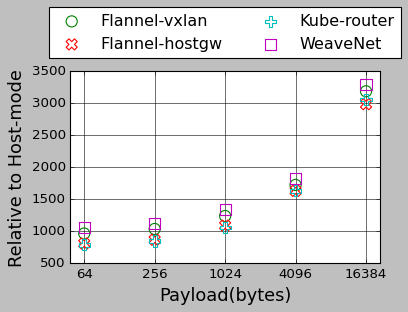

In [10]:
plt.figure(figsize=(5,3))
_, latency_perf = load_data(np.arange(len(data_len)), plugins, latencyTest=True)
x = np.arange(len(data_len))
plt.xticks(x, data_len)
total_width, n = 0.8, len(plugins)-1
width = total_width / n
# x = x - (total_width - width) / 2

baseline = latency_perf[latency_perf['cni'] == 'hostnetwork-udp']['90%'].to_numpy()
for i, cni in enumerate(plugins):
    if i == 0:
        continue
    # lat = latency_perf[latency_perf['cni'] == cni]['90%']
    # plt.plot(np.arange(6), lat, label=cni, marker='o')
    lat = latency_perf[latency_perf['cni'] == cni]['90%'].to_list()
    lat_err = latency_perf[latency_perf['cni'] == cni]['std'].to_list()
    # print(100*(lat/baseline - 1))
    plt.scatter(x, lat, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)
    # plt.scatter(x, lat/baseline, label=labels[i], marker=markers[i], c='',edgecolors='C%d'%(i), s=100)
#     plt.bar(x+(i-1)*width, lat/baseline, label=labels[i], width=width, yerr=lat_err/baseline, capsize=3)
    # print(cni, lat, lat_err)
    # plt.bar(x+i*width, lat, yerr=lat_err, width=width, label='-'.join(cni.split('-')[:-1]).upper(), capsize=3)

# plt.ylim(1.0)
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=2, loc='center', scatterpoints = 1)
plt.xlabel('Payload(bytes)', fontsize=16)
plt.ylabel('Relative to Host-mode', fontsize=16)
plt.grid(linestyle='-')
plt.savefig('latency.png', dpi=dpi, bbox_inches='tight')

Regarding to the ping-pong latency test, the average 90th latency overhead for each is Flannel-VXLAN=31.0%, Flannel-Hostgw=18.9%, Weavenet=41.7%, and Kuberouter=19.0%.  Also we can notice that Kuberouter has slightly lower latency than Flannel-Hostgw for smaller messages(<=1K<MTU) and inverse for larger ones, which implies that Kuberouter is more efficient in such synchronous communication when MTU is not the performance bottleneck. Besides, Weavnet has higher latency than Flannel-VXLAN even if the data length is smaller than MTU. According to the throughput test and the ping-pong latency test, we conclude that Flannel-Hostgw followed by Kube-router are more competitive comparing to Flannel-VXLAN and Weavnet. However, given the fact that Flannel-Hostgw requires Layer 2 inter-connectivity and lacks the support of K8s network policy, we believe Kuberouter is more applicable in practice.